# 304 compile metrics

In this notebook, we will calculate the following metrics:
1. eTCREup
2. TCREdown

We will add this to the other metrics:
1. eZEC
2. change_non_co2

In [1]:
import pyam
import pandas as pd
import numpy as np
from utils import (
    assign_warming_levels,
    _prep_df_for_subtract,
    calculate_netzero,
    strip_nz_suffix
)

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

/Users/gauravganti/anaconda3/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


## Read in the necessary data
Step 1: We read in the emissions data

In [2]:
df_emissions = pyam.IamDataFrame(
    Path(
        '../data/100_scenarios.csv'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/100_scenarios.csv


Step 2: Read in the original temperature data (to calculate eTCRE)

In [3]:
df_temperatures = pyam.IamDataFrame(
    Path(
        '../data/201_original_all_ghg_temps.csv'
    )
)

pyam.core - INFO: Reading file ../data/201_original_all_ghg_temps.csv


Step 3: Read in the CO2 drawdown data.

In [4]:
df_co2_drawdown = pd.read_csv(
    Path(
        '../data/301_co2_drawdown.csv'
    ),
    index_col=[0,1,2]
)

Step 4: Read in the eZEC data

In [5]:
df_zec = pd.read_csv(
    Path(
        '../data/302_ZEC.csv'
    )
)

Step 5: Read in the non CO2 change

In [6]:
df_nonco2_change = pd.read_csv(
    Path(
        '../data/303_nonco2_change.csv'
    ),
    index_col=[0,1,2]
)

## Data processing
Step 1: Handle the ZEC scenario labels.

In [7]:
df_zec = strip_nz_suffix(
    df_zec,
    return_as_ts=True
)

In [8]:
df_zec.set_index(
    ['model', 'scenario', 'run_id'],
    inplace=True
)

Step 2: Compile metrics into one dataframe (for the ones we have)

In [9]:
df_metrics = pd.concat(
    [
        df_co2_drawdown,
        df_zec,
        df_nonco2_change
    ],
    axis=1
)

In [10]:
df_metrics

drawdown_co2  \
model                 scenario                      run_id                 
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0           0.173288   
                                                    1           0.106326   
                                                    2           0.180099   
                                                    3           0.148464   
                                                    4           0.162020   
REMIND-MAgPIE 2.1-4.2 SusDev_SDP-PkBudg1000         0           0.039350   
                                                    1           0.053018   
                                                    2           0.040664   
                                                    3           0.032436   
                                                    4           0.037088   
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_ HighRE_Budg900 0           0.031644   
                                                    1          -0.002678   
                                                    2           0.031482   
                                                    3           0.026323   
                                                    4           0.030057   

                                                                 ZEC  \
model                 scenario                      run_id             
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0      -0.034173   
                                                    1      -0.013109   
                                                    2      -0.025046   
                                                    3      -0.063790   
                                                    4      -0.037898   
REMIND-MAgPIE 2.1-4.2 SusDev_SDP-PkBudg1000         0      -0.036442   
                                                    1      -0.013612   
                                                    2      -0.023099   
                                                    3      -0.065566   
                                                    4      -0.042074   
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_ HighRE_Budg900 0      -0.041529   
                                                    1      -0.008364   
                                                    2      -0.038951   
                                                    3      -0.075703   
                                                    4      -0.047712   

                                                            change_non_co2  
model                 scenario                      run_id                  
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0             0.029602  
                                                    1             0.013666  
                                                    2             0.013126  
                                                    3            -0.026165  
                                                    4             0.022756  
REMIND-MAgPIE 2.1-4.2 SusDev_SDP-PkBudg1000         0            -0.237951  
                                                    1            -0.142832  
                                                    2            -0.232387  
                                                    3            -0.279659  
                                                    4            -0.334983  
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_ HighRE_Budg900 0            -0.023157  
                                                    1            -0.007957  
                                                    2             0.001200  
                                                    3            -0.063334  
                                                    4            -0.049273

Step 3: Calculate the temperature rise to peak warming

In [11]:
temp_rise = assign_warming_levels(
    df_temperatures,
    assign_peak_year=True,
    include_2015=True
)

Step 4: Select the columns to keep.

In [12]:
columns = [
    '2015_warming',
    '2100_warming',
    'peak_warming',
    'year_peak_warming',
]

In [13]:
temps_to_add = (
    temp_rise
    .set_index(
        [
            'model',
            'scenario',
            'run_id'
        ]
    )
    .loc[:,columns]
)

Step 5: Concatenate this to the metrics dataframe.

In [14]:
df_metrics = pd.concat(
    [
        df_metrics,
        temps_to_add
    ],
    axis=1
)

Step 6: Pull out the CO2 emissions for each scenario.

In [15]:
df_emissions_to_assess = (
    df_emissions.
    filter(
        variable=['*Emissions|CO2*']
    )
    .swap_time_for_year()
    .aggregate(
        variable='Emissions|CO2',
        components=[
            'AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes',
            'AR6 climate diagnostics|Infilled|Emissions|CO2|AFOLU'
        ]
    )
    .convert_unit(
        current='Mt CO2/yr',
        to='Gt CO2/yr'
    )
)

Step 7: Assign cumulative emissions from 2015 --> peak

In [16]:
for (model, scenario, run_id), value in df_metrics.iterrows():
    # Step 7.1: Filter for the model and scenario
    emission_ts = (
        df_emissions_to_assess
        .filter(
            model=model,
            scenario=scenario
        )
        .timeseries()
    )
    # Step 7.2: Calculate cumulative emissions to peak
    cum_emissions_to_peak = (
        emission_ts
        .apply(
            lambda x: pyam.cumulative(
                x,
                first_year=2015,
                last_year=int(value['year_peak_warming'])
            ),
            axis=1
        )
        .values[0]
    )
    df_metrics.loc[(model, scenario, run_id), 'cum_emissions_to_peak_GtCO2'] = cum_emissions_to_peak
    # Step 7.3: Calculate cumulative emissions after peak
    cum_emissions_after_peak = (
        emission_ts
        .apply(
            lambda x: pyam.cumulative(
                x,
                first_year=int(value['year_peak_warming']),
                last_year=2100
            ),
            axis=1
        )
        .values[0]
    )
    df_metrics.loc[(model, scenario, run_id), 'cum_emissions_after_peak_GtCO2'] = cum_emissions_after_peak

In [17]:
df_metrics

drawdown_co2  \
model                 scenario                      run_id                 
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0           0.173288   
                                                    1           0.106326   
                                                    2           0.180099   
                                                    3           0.148464   
                                                    4           0.162020   
REMIND-MAgPIE 2.1-4.2 SusDev_SDP-PkBudg1000         0           0.039350   
                                                    1           0.053018   
                                                    2           0.040664   
                                                    3           0.032436   
                                                    4           0.037088   
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_ HighRE_Budg900 0           0.031644   
                                                    1          -0.002678   
                                                    2           0.031482   
                                                    3           0.026323   
                                                    4           0.030057   

                                                                 ZEC  \
model                 scenario                      run_id             
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0      -0.034173   
                                                    1      -0.013109   
                                                    2      -0.025046   
                                                    3      -0.063790   
                                                    4      -0.037898   
REMIND-MAgPIE 2.1-4.2 SusDev_SDP-PkBudg1000         0      -0.036442   
                                                    1      -0.013612   
                                                    2      -0.023099   
                                                    3      -0.065566   
                                                    4      -0.042074   
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_ HighRE_Budg900 0      -0.041529   
                                                    1      -0.008364   
                                                    2      -0.038951   
                                                    3      -0.075703   
                                                    4      -0.047712   

                                                            change_non_co2  \
model                 scenario                      run_id                   
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0             0.029602   
                                                    1             0.013666   
                                                    2             0.013126   
                                                    3            -0.026165   
                                                    4             0.022756   
REMIND-MAgPIE 2.1-4.2 SusDev_SDP-PkBudg1000         0            -0.237951   
                                                    1            -0.142832   
                                                    2            -0.232387   
                                                    3            -0.279659   
                                                    4            -0.334983   
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_ HighRE_Budg900 0            -0.023157   
                                                    1            -0.007957   
                                                    2             0.001200   
                                                    3            -0.063334   
                                                    4            -0.049273   

                                                            2015_warming  \
model                 scenario                      run_id                 
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0          

Step 8: Calculate the eTCREup

In [18]:
df_metrics.loc[:, 'eTCREup'] = (
    (df_metrics.loc[:,'peak_warming'] - df_metrics.loc[:,'2015_warming'])
    /
    df_metrics.loc[:,'cum_emissions_to_peak_GtCO2']
)

Step 9: Calculate the eTCREdown.

In [19]:
df_metrics.loc[:, 'eTCREdown'] = (
    (df_metrics.loc[:,'drawdown_co2'])
    /
    df_metrics.loc[:,'cum_emissions_after_peak_GtCO2']
)

Step 10: Quick plot?

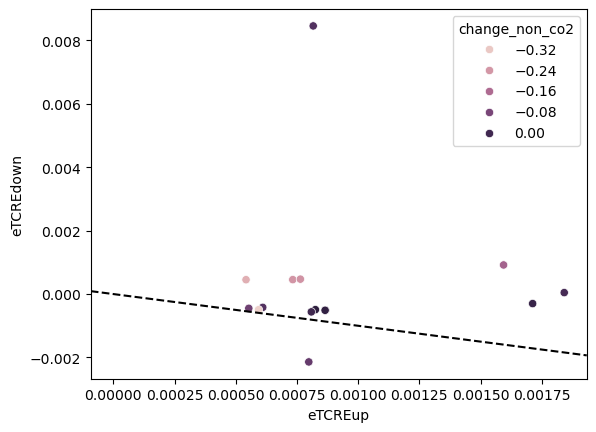

In [20]:
fig, ax = plt.subplots()

sns.scatterplot(
    data=df_metrics,
    x='eTCREup',
    y='eTCREdown',
    hue='change_non_co2'
)

ax.axline(
    (0, 0), 
    slope=-1,
    color='black',
    linestyle='dashed'
)

In [21]:
df_metrics

drawdown_co2  \
model                 scenario                      run_id                 
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0           0.173288   
                                                    1           0.106326   
                                                    2           0.180099   
                                                    3           0.148464   
                                                    4           0.162020   
REMIND-MAgPIE 2.1-4.2 SusDev_SDP-PkBudg1000         0           0.039350   
                                                    1           0.053018   
                                                    2           0.040664   
                                                    3           0.032436   
                                                    4           0.037088   
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_ HighRE_Budg900 0           0.031644   
                                                    1          -0.002678   
                                                    2           0.031482   
                                                    3           0.026323   
                                                    4           0.030057   

                                                                 ZEC  \
model                 scenario                      run_id             
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0      -0.034173   
                                                    1      -0.013109   
                                                    2      -0.025046   
                                                    3      -0.063790   
                                                    4      -0.037898   
REMIND-MAgPIE 2.1-4.2 SusDev_SDP-PkBudg1000         0      -0.036442   
                                                    1      -0.013612   
                                                    2      -0.023099   
                                                    3      -0.065566   
                                                    4      -0.042074   
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_ HighRE_Budg900 0      -0.041529   
                                                    1      -0.008364   
                                                    2      -0.038951   
                                                    3      -0.075703   
                                                    4      -0.047712   

                                                            change_non_co2  \
model                 scenario                      run_id                   
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0             0.029602   
                                                    1             0.013666   
                                                    2             0.013126   
                                                    3            -0.026165   
                                                    4             0.022756   
REMIND-MAgPIE 2.1-4.2 SusDev_SDP-PkBudg1000         0            -0.237951   
                                                    1            -0.142832   
                                                    2            -0.232387   
                                                    3            -0.279659   
                                                    4            -0.334983   
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_ HighRE_Budg900 0            -0.023157   
                                                    1            -0.007957   
                                                    2             0.001200   
                                                    3            -0.063334   
                                                    4            -0.049273   

                                                            2015_warming  \
model                 scenario                      run_id                 
COFFEE 1.1            EN_NPi2020_400f_lowBECCS      0          

## Save out the data

In [22]:
df_metrics.to_csv(
    Path(
        '../data/304_compiled_metrics.csv'
    )
)